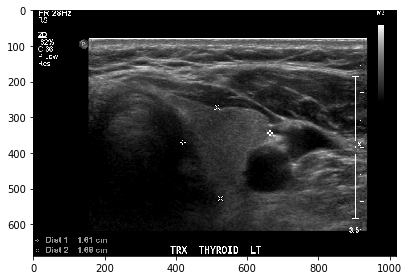

In [2]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import cv2
import numpy as np 	
from skimage import io
import skimage.morphology as morph
import skimage.color as color
import skimage.measure as measure
import skimage.feature as feature
import skimage.util as util
from sklearn.feature_extraction.image import extract_patches_2d 
from scipy.fftpack import dctn
from scipy.fftpack import idctn

import matplotlib.pyplot as plt
%matplotlib inline

# Read image file
img = cv2.imread("Data/1 Left Trans Normal Marked.tif")
#img = cv2.imread("Data/1 Left Sag Normal.tif")
#img = cv2.imread("Data/1 Right Sag Mass.tif")
#img = cv2.imread("Data/6 Right Trans Mass Marked.tif")
#img = cv2.imread("Data/179 Left Sag Mass Marked.tif")


# Display image
io.imshow(img)

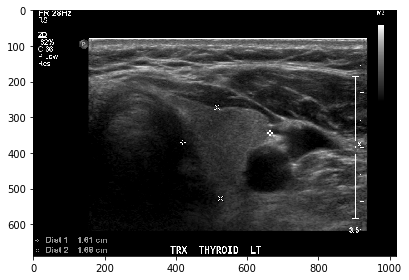

In [3]:
# Convert image to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Display grayscale image
io.imshow(gray)

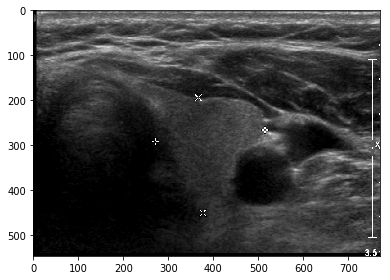

In [4]:
# Threshold image to form a binary image
# Label the binary image and retain (crop image) the connected component with largest area

ret,thresh = cv2.threshold(gray, 0, 255, 0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, 
                                                                    cv2.CHAIN_APPROX_SIMPLE)
areas = [cv2.contourArea(c) for c in contours]
max_index = np.argmax(areas)
cnt=contours[max_index]
x, y, w, h = cv2.boundingRect(cnt)
crop_img_for_tick_bar = gray[y:y+h, x+20:x+w+40]
crop_img = gray[y:y+h, x+20:x+w-20]
io.imshow(crop_img)

<BarContainer object of 256 artists>

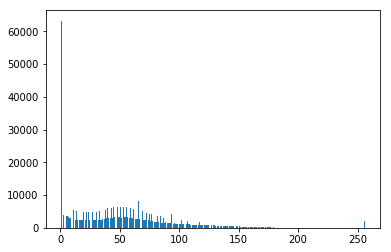

In [5]:
# Histogram of image

img_hist, bin_edges = np.histogram(crop_img, bins=256, range=(0, 255))
plt.figure()
plt.bar(range(1, 257, 1), img_hist)

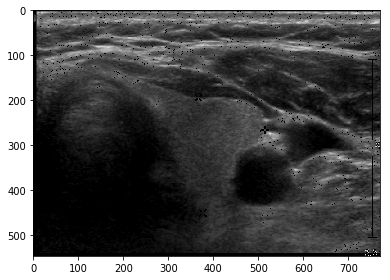

In [8]:
# Divide graylevel of histogram into 3 parts (0:100; 101:200; 201:255)

hist_1 = img_hist[0:101]
hist_2 = img_hist[101:201]
hist_3 = img_hist[201:256]

# Find the histogram peak at each of the three divided parts
hist_1_peak = np.argmax(hist_1)+1
hist_2_peak = np.argmax(hist_2)+101
hist_3_peak = np.argmax(hist_3)+201

# Declare a binary mask (initially all zeros) of same size as the cropped image
bin_mask = np.zeros_like(crop_img, dtype=bool)

# Get all the x,y co-ordinates where the cropped image has the same intensity as the histogram peaks
pts_1 = np.where(crop_img == hist_1_peak)
pts_1 = np.transpose(np.vstack(pts_1))

pts_2 = np.where(crop_img == hist_2_peak)
pts_2 = np.transpose(np.vstack(pts_2))

pts_3 = np.where(crop_img == hist_3_peak)
pts_3 = np.transpose(np.vstack(pts_3))

# Assign all the x,y points collected as 1 (True) in binary mask
for r,c in pts_1:
    bin_mask[r, c] = True
    
for r,c in pts_2:
    bin_mask[r, c] = True

for r,c in pts_3:
    bin_mask[r, c] = True

# Invertbinary mask
bin_mask_inv = np.invert(bin_mask)
io.imshow(bin_mask_inv)

# Multiply binary mask with cropped image to remove predicted artifacts
out_img = crop_img*bin_mask_inv

# Show output image with predicted artifacts removed
io.imshow(out_img)

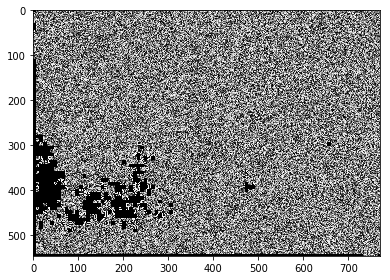

In [9]:
# Restore the "gap" after removing the artifacts pixels by simulating the surrounding textures

# Pad the image so to get inter number of 8 X 8 blocks
r, c = out_img.shape
r_pad = 8 - (r % 8)
c_pad = 8 - (c % 8)

r_pad_l = int(np.floor(r_pad/2))
r_pad_r = int(np.ceil(r_pad/2))

c_pad_l = int(np.floor(c_pad/2))
c_pad_r = int(np.ceil(c_pad/2))

out_img_pad = np.pad(crop_img, ((r_pad_l, r_pad_r), (c_pad_l, c_pad_r)), mode='symmetric')

row_pad = out_img_pad.shape[0]
col_pad = out_img_pad.shape[1]

# Compute the two-dimensional DCT of 8-by-8 blocks in the image
mask = [[1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]
        
idct_img = np.zeros_like(out_img_pad)

for row in range(0, row_pad-1, 8):
    for col in range(0, col_pad-1, 8):
        img_patch = out_img_pad[row:row+8, col:col+8]
        dct_img_patch = dctn(img_patch)
        
        # Discard all but 10 of the 64 DCT coefficients in each block and compute the Inverse DCT
        dct_img_patch = dct_img_patch*mask
        
        # Inverse DCT
        idct_img[row:row+8, col:col+8] = idctn(dct_img_patch)
        
# Reduce the Inverse DCT image to same size as the original
idct_img = idct_img[r_pad_l:row_pad-r_pad_r, c_pad_l:col_pad-c_pad_r]

# Show the inverse DCT computed for 8 X 8 blocks of the image after artifact removal
io.imshow(idct_img)

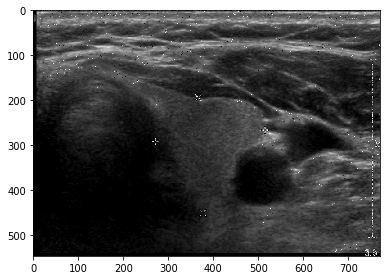

In [11]:
# Only the "gaps" are replaced by the approximated textures, preserve the original textures
corr_img = (idct_img*bin_mask)+out_img

# Show the image corrected after artifact removal using inverse DCT to approximate neighbouring regions
io.imshow(corr_img)

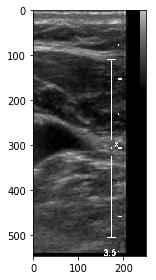

In [12]:
# Crop the right 70% of the image to detect tick bar
crop_img_h, crop_img_w = crop_img_for_tick_bar.shape
img_tick = crop_img_for_tick_bar[:, int(0.70*crop_img_w):crop_img_w]
io.imshow(img_tick)

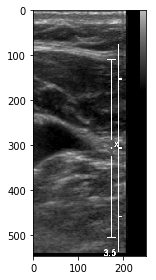

In [13]:
# Detect the column containing tick bar by estimating intensity peaks
img_tick_h, img_tick_w = img_tick.shape
peaks = []
column = 0
for i in range(0, img_tick_w-1, 1):
    col = img_tick[:, i]
    peak_pts = feature.peak.peak_local_max(col, min_distance=10, threshold_abs=250, num_peaks=100)
    if peak_pts.shape[0] > 15 and peak_pts.shape[0] < 25:
        peaks = peak_pts
        column = i
        break
    
# Show the column containing tick bar as a line
img_tick_copy = img_tick
tick_line_img = cv2.line(img_tick_copy, (column, np.min(peaks)), (column, np.max(peaks)), (255, 255, 0),2)
io.imshow(tick_line_img)

In [14]:
# Measure the tick bar distance in pixels
tick_distance_px = np.max(peaks) - np.min(peaks)
print(tick_distance_px)

459
